In [3]:
# download files (if you're on colab)
%%capture
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py

In [1]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import compute_loss, compute_bleu

# Data

In [ ]:
# Tokenizing & applying BPE rules (if you're on colab)

tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt', encoding='utf-8'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')


# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)  # 1. learn_bpe rules
    bpe[lang] = BPE(open('./bpe_rules.' + lang))  # 2. create instance of BPE class
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')  # 3. apply BPE tokenization to our data 

In [2]:
# Building vocabularies

data_inp = np.array(open('./train.bpe.ru', encoding='utf-8', mode='r').read().split('\n'))
data_out = np.array(open('./train.bpe.en', encoding='utf8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')            

from vocab import Vocab

inp_voc = Vocab.from_lines(train_inp) # creates an instance of Vocab class from input lines (ru (input) vocab here)
out_voc = Vocab.from_lines(train_out) # en (output) vocab

print(f'Length of input (Russian) BPE vocabulary = {len(inp_voc)}')
print(f'Length of output (English) BPE vocabulary = {len(out_voc)}')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .

Length of input (Russian) BPE vocabulary = 8048
Length of output (English) BPE vocabulary = 7801


# Encoder-decoder models

## Basic model (Single GRU/GRU, no attention or anything)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
from models import BasicModel

model = BasicModel(inp_voc, out_voc).to(device)

# debugging area

dummy_inp_tokens = inp_voc.to_matrix(train_inp[:5]).to(device)
dummy_out_tokens = out_voc.to_matrix(train_out[:5]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

# Loss:

from utils import compute_loss

dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 8.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

# Evaluation: BLEU

from utils import compute_bleu

# BLEU of untrained model
%time print(f"BLEU of untarined model: {compute_bleu(model, dev_inp, dev_out, device=device)}")

Loss: tensor(8.5019, grad_fn=<NegBackward0>)
BLEU of untarined model: 0.00307524805087033
Wall time: 1min 27s


In [3]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from utils import save_checkpoint, load_checkpoint

In [5]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from utils import save_checkpoint, load_checkpoint

model = BasicModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [6]:
# training

def train_loop(model, optimizer, train_inp, num_epochs=25000, from_checkpoint=False):   

    metrics = {'train_loss': [], 'dev_bleu': [] }

    if from_checkpoint:
        best_checkpoint = torch.load('/content/best_bleu_state.pth')
        model.load_state_dict(best_checkpoint["state_dict"])
        best_bleu = best_checkpoint['bleu']
    else:
        best_bleu = 0

    for epoch in trange(num_epochs):
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
        
        optimizer.zero_grad() # set the gradients to zero before backpropagation
        loss_t = compute_loss(model, batch_inp, batch_out)
        loss_t.backward()
        optimizer.step()

        
        metrics['train_loss'].append((epoch+1, loss_t.item()))
        
        if (epoch+1) % 100 == 0:
            bleu = compute_bleu(model, dev_inp, dev_out, device=device)
            metrics['dev_bleu'].append((epoch+1, bleu))
            
            if bleu > best_bleu:
                best_bleu = bleu
                checkpoint = {
                    'state_dict' : deepcopy(model.state_dict()), 
                    'optimizer' : deepcopy(optimizer.state_dict()),
                    'epoch' : epoch+1,
                    'bleu' : bleu,
                }
                save_checkpoint(checkpoint, filename="best_bleu_state.pth")

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    
    return metrics

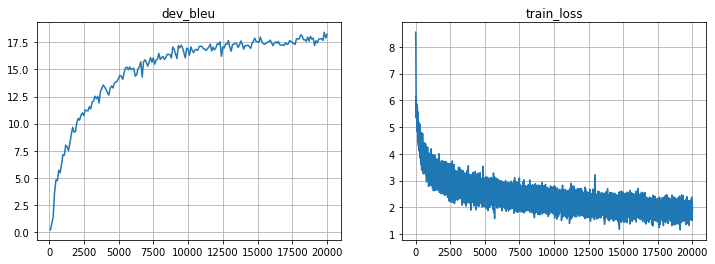

Mean loss=1.862


100%|██████████| 20000/20000 [28:45<00:00, 11.59it/s]


In [12]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=20000,
    from_checkpoint=False
)

In [13]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

print('Mean BLEU on last 10 epoches = ', np.mean(metrics['dev_bleu'][-10:], axis=0)[1]) # Simple GRU/GRU model without attention

best BLEU =  18.440207574411225
best epoch =  19800
Mean BLEU on last 10 epoches =  17.808018819260816


### Beam research

In [14]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


In [4]:
def beam_research(model, inp, out, model_name, beam_min=1, beam_max=10):
    """BLEU scores of a model with different beam_size"""
    
    beam_range = range(beam_min, beam_max + 1)
    blue_scores = []

    for beam_size in beam_range:
        blue = compute_bleu(model, inp, out, beam_size=beam_size, device=device)
        blue_scores.append(blue)

    plt.figure(figsize=(12, 5))
    plt.plot(beam_range, blue_scores)
    plt.title('Beam search results for %s' % model_name)
    plt.xticks(beam_range)
    plt.xlabel('beam size')
    plt.ylabel('BLEU score')
    plt.show()

In [9]:
%time beam_research(model, dev_inp, dev_out, 'basic model')

KeyboardInterrupt: ignored

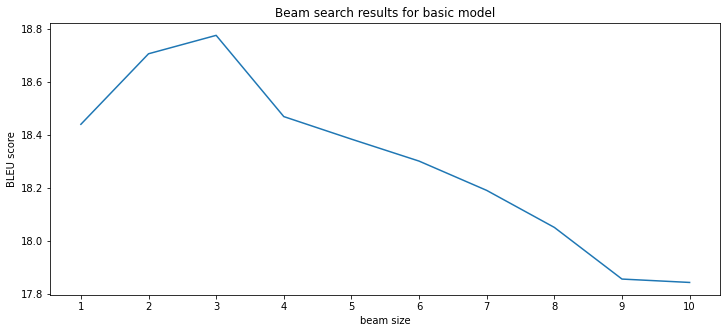

CPU times: user 15min 38s, sys: 9.42 s, total: 15min 48s
Wall time: 15min 49s


In [16]:
%time beam_research(model, dev_inp, dev_out, 'basic model')

### BasicModel translations

In [6]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device=device, beam_size=2)[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: ĭ@@ individually belorus@@ bicycle kath@@ kir@@ kir@@ light closed programme prat@@ adults für@@ toast gage toast è@@ ries ries prat hol@@ naz@@ strasse covered bolzano hl@@ polit@@ extras ș@@ british british s uti@@ uti@@ uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ ching uti@@ uti@@ nas@@
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: ĭ@@ individually belorus@@ bicycle kath@@ kir@@ kir@@ light closed programme prat@@ adult

## Attentive model (Single GRU/GRU + attention mechanism)

In [8]:
from models import AttentiveModel

model = AttentiveModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

NameError: name 'device' is not defined

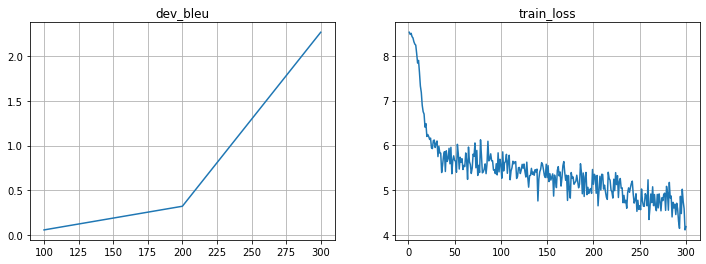

Mean loss=4.503


  2%|▏         | 399/20000 [01:06<54:14,  6.02it/s]


KeyboardInterrupt: ignored

In [20]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=20000,
    from_checkpoint=False
)

In [ ]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

print('Mean BLEU on last 10 epoches = ', np.mean(metrics['dev_bleu'][-10:], axis=0)[1]) # Luong attentive model BLEU

In [15]:
more models.py

### Beam research 

In [17]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


NameError: name 'best_checkpoint' is not defined

In [9]:
%time beam_research(model, dev_inp, dev_out, 'attentive model')

NameError: name 'model' is not defined

### AttentiveModel translations

In [9]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device='cuda')[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: building vegetable ises pei boasts field ło@@ zal@@ ser working clo@@ stol@@ harbor ingual pulkovo cristo@@ milk building diego ented alph@@ å@@ å@@ organiz@@ organiz@@ sar@@ comes poli@@ full mediterran@@ bathrobes pulkovo new saar@@ etna che@@ ferry pper limassol janeiro hn em@@ 7@@ visits ota ticketing ther@@ nings reland vi@@ vi@@ vi@@ useful useful cereals wan@@ rol petersburg balcony pulkovo limassol rol bam@@ af residencial residencial lumpur dam tre petro@@ uple т bas@@ ada ways eni@@ ube architecture ю@@ eira sch taviano indian fol@@ shower hammocks bre@@ salt ological wind banquet siam este kh@@ ical juices ior communal ay dune
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: every uk@@ photocop@@ kers chiado homewood nings zhu@@ casual 